# AE 483: Final Project
### Quadcopter Search and Rescue Simulation

Charlie Ray, Dennis McCann, Vivek Kodali, Michael Biela

**Note that most of the code included in this notebook was derived from, if not copy/pasted directly from, the notebooks provided by Dr. Bretl for the labs associated with this course. Special thanks to him, and other members of course staff, for their help in bringing this project to fruition.**

# 1. Setup the Notebook

## 1.1. Import modules

In [205]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d

## 1.2. Define Functions

Define a function to load data from hardware. 

In [206]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        if 'ae483log.o_z_des' not in resampled_data.keys():
            raise Exception('"ae483log.o_z_des" must be logged')
        i = np.argwhere(resampled_data['ae483log.o_z_des'] > 0).flatten()
        if len(i) == 0:
            raise Exception('o_z_des was never positive')
        if len(i) < 2:
            raise Exception('o_z_des was only positive for one time step')
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to export power distribution code. The output can be copy/pasted directly into code and run.

In [207]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

Define a function to export a controller given states, inputs, and a gain matrix. The output can be copy/pasted directly into code and run.

In [208]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

Define a function to parse drone data from a .json file to something that's easier to manipulate and plot

In [209]:
def resample(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to solve for a gain matrix using LQR

In [210]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

Define a function to determine whether or not a system is fully observable

In [211]:
def obsv(A, C):
    W = C
    for i in range(1, A.shape[0]):
        W = np.vstack([W, C @ np.linalg.matrix_power(A, i)])
    return W

# 2. Derive Models

## 2.1. Symbolic Variables

In [212]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# z-axis accelerometer measurement - specific force (meters / second^2)
a_z = sym.symbols('a_z')

# other measurements
n_x, n_y, r = sym.symbols('n_x, n_y, r')

# x, y, and z positions of loco anchors plus distances from anchors to tag
x0, y0, z0, d0 = sym.symbols('x0, y0, z0, d0')
x1, y1, z1, d1 = sym.symbols('x1, y1, z1, d1')
x2, y2, z2, d2 = sym.symbols('x2, y2, z2, d2')
x3, y3, z3, d3 = sym.symbols('x3, y3, z3, d3')
x4, y4, z4, d4 = sym.symbols('x4, y4, z4, d4')
x5, y5, z5, d5 = sym.symbols('x5, y5, z5, d5')
x6, y6, z6, d6 = sym.symbols('x6, y6, z6, d6')
x7, y7, z7, d7 = sym.symbols('x7, y7, z7, d7')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m, J_x, J_y, J_z, g = sym.symbols('m, J_x, J_y, J_z, g')

# optical flow coefficient
k_flow = sym.symbols('k_flow')

## 2.2. Controller

### 2.2.1. Rotation Matrix in terms of Yaw, Pitch, and Roll Angles

Create linear and angular velocity vectors (in coordinates of the body frame)

In [213]:
v_01in1 = sym.Matrix([[v_x], [v_y], [v_z]])
w_01in1 = sym.Matrix([[w_x], [w_y], [w_z]])

Define individual rotation matrices

In [214]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone

In [215]:
R_1in0 = Rz * Ry * Rx

### 2.2.2. Map from Angular Velocities to Angular Rates

This can be done using the following equation:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

In [216]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([[0], [0], [1]]),
                              (Rx).T * sym.Matrix([[0], [1], [0]]),
                                       sym.Matrix([[1], [0], [0]]))
        
N = sym.simplify(Ninv.inv())

### 2.2.3. Define Equations of Motion

Forces:

In [217]:
f_in1 = R_1in0.T * sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

Torques:

In [218]:
tau_in1 = sym.Matrix([[tau_x], [tau_y], [tau_z]])

Create a moment of inertia matrix (in coordinates of the body frame)

In [219]:
J_in1 = sym.diag(J_x, J_y, J_z)
s_with_des = [o_x, o_y, o_z]

Equations of Motion:

In [220]:
f_sym_con = sym.Matrix.vstack(
    R_1in0 * v_01in1,
    N * w_01in1,
    (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
    J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)))

These Equations of Motion have the following form:

$$\dot{s} = f(s, i, p)$$

where

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ \omega_x \\ \omega_y \\ \omega_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
\qquad\qquad
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [221]:
f_sym_con

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

## 2.3. State-Space Model

Define constants

In [222]:
# Mass
m_val = 0.032    # <-- FIXME

# Principle moments of inertia
J_x_val = 1.58e-05  # <-- FIXME
J_y_val = 1.56e-05  # <-- FIXME
J_z_val = 2.12e-05  # <-- FIXME

# J_x_val = 0.00002079685  
# J_y_val = 0.00002122075  
# J_z_val = 0.000030112233 


# Acceleration of gravity
g_val = 9.81

# Optical Flow Coefficient value
k_flow_val = 0.01 * 30.0 / np.deg2rad(4.2)

# Coefficients for generated forces and moments
k_F = 2.08e-06 # <-- FIXME
k_M = 4.47e-09 # <-- FIXME

# Distance from C.O.M to drone motor
l = 0.035  # <-- FIXME

# Anchor Positions
x0_val = -1.50
y0_val = -1.60
z0_val = 0.33

x1_val = -1.45
y1_val = 1.78
z1_val = 1.87

x2_val = 1.83
y2_val = 1.78
z2_val = 0.34

x3_val = 1.78
y3_val = -1.59
z3_val = 1.88

x4_val = -1.52
y4_val = -1.57
z4_val = 1.88

x5_val = -1.52
y5_val = 1.79
z5_val = 0.33

x6_val = 1.87
y6_val = 1.79
z6_val = 1.85

x7_val = 1.82
y7_val = -1.59
z7_val = 0.32

Create a list of states, inputs, and parameters for the controller as symbolic variables.

In [223]:
s_con = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i_con = [tau_x, tau_y, tau_z, f_z]
p_con = [m, J_x, J_y, J_z, g]

Lambdify the equations of motion for the controller so we can substitute in numerical values

In [224]:
f_con = sym.lambdify(s_con + i_con + p_con, f_sym_con)

Define equilibrium position of the drone

In [225]:
o_x_eq = 0.
o_y_eq = 0.
o_z_eq = 0.5

Combine defined equilibrium values into arrays for the controller states, inputs, and parameters

In [226]:
s_eq_con = [o_x_eq, o_y_eq, o_z_eq, 0., 0., 0., 0., 0., 0., 0., 0., 0.] # <-- FIXME
i_eq_con = [0., 0., 0., m_val*g_val]                    # <-- FIXME
p_eq_con = [m_val, J_x_val, J_y_val, J_z_val, g_val]

Verify that the values chosen above actually correspond to an equilibrium condition

In [227]:
print(f_con(*s_eq_con, *i_eq_con, *p_eq_con))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


## 2.4. Compute $A$ and $B$ Matrices for the Controller

**Note that we don't need the $C$ and $D$ matrices for the controller, so we aren't going to compute them**

Create symbolic arrays for $A$ and $B$ by taking the jacobian of the equations of motion (f) with respect to the states and inputs, respectively

In [228]:
A_sym_con = f_sym_con.jacobian(s_con).subs(tuple(zip(s_con, s_eq_con))).subs(tuple(zip(i_con, i_eq_con)))
B_sym_con = f_sym_con.jacobian(i_con).subs(tuple(zip(s_con, s_eq_con))).subs(tuple(zip(i_con, i_eq_con)))

Lambdify the symbolic $A$ and $B$ matrices so numerical values can be substituted in

In [229]:
A_num_con = sym.lambdify(s_con + i_con + p_con, A_sym_con)
A_con = A_num_con(*s_eq_con, *i_eq_con, *p_eq_con)

B_num_con = sym.lambdify(s_con + i_con + p_con, B_sym_con)
B_con = B_num_con(*s_eq_con, *i_eq_con, *p_eq_con)

In [230]:
sym.Matrix(A_con)

Matrix([
[0, 0, 0, 0,    0,     0, 1.0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0, 1.0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0, 1.0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0, 1.0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0, 1.0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0, 1.0,   0,   0],
[0, 0, 0, 0, 9.81,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0, -9.81,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0,   0,   0,   0]])

In [231]:
sym.Matrix(B_con)

Matrix([
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0,     0],
[               0,                0,                0, 31.25],
[63291.1392405063,                0,                0,     0],
[               0, 64102.5641025641,                0,     0],
[               0,                0, 47169.8113207547,     0]])

## 2.5. Compute the Gain Matrix $K$ for the Controller

Define an array $P$ to relate desired torques and the resultant force to each motor power command

In [232]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Pinv = linalg.inv(P)

Use Bryson's Rule to determine the optimal weights matrix for the controller inputs

In [233]:
# determine the maximum allowable motor power command
m_max = Pinv @ np.array([[0], [0], [0], [m_val*g_val]])

# find the difference between the maximum allowable and maximum possible motor power command
m_max_diff = 65535 - m_max[0][0]

# convert from total power command to individual power command (for each motor)
m_max_diff_indiv = m_max_diff/4

# compute maximum allowable torques and resultant force
tx_max = l*k_F*(4*m_max_diff_indiv)
ty_max = l*k_F*(4*m_max_diff_indiv)
tz_max = k_M*(4*m_max_diff_indiv)
fz_max = k_F*(4*m_max_diff_indiv)

# compute weights and combine into matrix
r1 = (1/tx_max)**2
r2 = (1/ty_max)**2
r3 = (1/tz_max)**2
r4 = (1/fz_max)**2

R_bryson = np.diag([r1, r2, r3, r4])

# R_con = 17 * R_bryson

Create weights matrix for the controller states. These values were determined through trial and error during lab 6

In [234]:
# Q_con = np.diag([
#     55.,
#     55.,
#     200.,
#     115.,
#     13.5,
#     13.5,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.,
#     1.
# ])

Q_con = np.diag([
    100,
    100,
    100,
    0.02533,
    0.40528,
    0.40528,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R_con = np.diag([
    426808.,
    426808.,
    426808.,
    426808.,
])

Combine the $Q$ and $R$ matrices from above, alongside the $A$ and $B$ matrices calculated in section 2.4 using LQR to determine the matrix of gains for the controller, $K$

In [235]:
K = lqr(A_con, B_con, Q_con, R_con)

Export controller code (in C for the firmware) using the matrix of gains $K$

In [236]:
export_controller(
    K,               # the gain matrix
    s_con,               # list of states as symbolic variables
    i_con,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq_con,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.01530678f * (o_y - o_y_des) -0.01509649f * phi + 0.00703234f * v_y -0.00167929f * w_x;
tau_y = -0.01530678f * (o_x - o_x_des) -0.01508778f * theta -0.00703041f * v_x -0.00167741f * w_y;
tau_z = -0.00024361f * psi -0.00153405f * w_z;
f_z = -0.01530678f * (o_z - o_z_des) -0.03133651f * v_z + 0.31392000f;


Export a method of power distribution (in C for the firmware) using the matrix $P$ calculated earlier

In [237]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -3434065.9f * tau_x -3434065.9f * tau_y -55928411.6f * tau_z + 120192.3f * f_z );
m_2 = limitUint16( -3434065.9f * tau_x + 3434065.9f * tau_y + 55928411.6f * tau_z + 120192.3f * f_z );
m_3 = limitUint16( 3434065.9f * tau_x + 3434065.9f * tau_y -55928411.6f * tau_z + 120192.3f * f_z );
m_4 = limitUint16( 3434065.9f * tau_x -3434065.9f * tau_y + 55928411.6f * tau_z + 120192.3f * f_z );


## 2.6. Observer

Build an array of measurement equations

In [238]:
h = sym.Matrix([
    k_flow * (v_x - o_z * w_y) / o_z,                            # <-- x flow (n_x)
    k_flow * (v_y + o_z * w_x) / o_z,                            # <-- y flow (n_y)
    o_z / (sym.cos(phi) * sym.cos(theta)),                       # <-- z range (r)
    ((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**(1/2),      # < -- distance from anchor 0 (d0)
    ((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**(1/2),      # < -- distance from anchor 1 (d1)
    ((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**(1/2),      # < -- distance from anchor 2 (d2)
    ((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**(1/2),      # < -- distance from anchor 3 (d3)
    ((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**(1/2),      # < -- distance from anchor 4 (d4)
    ((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**(1/2),      # < -- distance from anchor 5 (d5)
    ((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**(1/2),      # < -- distance from anchor 6 (d6)
    ((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**(1/2)       # < -- distance from anchor 7 (d7)
])


In [239]:
h

Matrix([
[                         k_flow*(-o_z*w_y + v_x)/o_z],
[                          k_flow*(o_z*w_x + v_y)/o_z],
[                           o_z/(cos(phi)*cos(theta))],
[((o_x - x0)**2 + (o_y - y0)**2 + (o_z - z0)**2)**0.5],
[((o_x - x1)**2 + (o_y - y1)**2 + (o_z - z1)**2)**0.5],
[((o_x - x2)**2 + (o_y - y2)**2 + (o_z - z2)**2)**0.5],
[((o_x - x3)**2 + (o_y - y3)**2 + (o_z - z3)**2)**0.5],
[((o_x - x4)**2 + (o_y - y4)**2 + (o_z - z4)**2)**0.5],
[((o_x - x5)**2 + (o_y - y5)**2 + (o_z - z5)**2)**0.5],
[((o_x - x6)**2 + (o_y - y6)**2 + (o_z - z6)**2)**0.5],
[((o_x - x7)**2 + (o_y - y7)**2 + (o_z - z7)**2)**0.5]])

Redefine the equations of motion for the observer

In [240]:
f_z_over_m = a_z + (w_01in1.cross(v_01in1))[2]

f_in1_over_m = R_1in0.T * sym.Matrix([[0], [0], [-g]]) + sym.Matrix([[0], [0], [f_z_over_m]])

f_obs = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (f_in1_over_m - w_01in1.cross(v_01in1)),
)


These measurement equations have the form

$$o = h(s, i, p)$$

where

$$
o = \begin{bmatrix} n_x \\ n_y \\ r \\ d_0 \\ d_1 \\ d_2 \\ d_3 \\ ... \\ d_7 \end{bmatrix}
\qquad\qquad
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \end{bmatrix}
\qquad\qquad
i = \begin{bmatrix} w_x \\ w_y \\ w_z \\ a_z \end{bmatrix}
\qquad\qquad
p = \begin{bmatrix} g \\ k_\text{flow} \end{bmatrix}.
$$

Create arrays for the states, inputs, outputs, and parameters for the observer

In [241]:
# Old state, input, output and parameters
s_obs = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z]
i_obs = [w_x, w_y, w_z, a_z]
o_obs = [n_x, n_y, r, d0, d1, d2, d3, d4, d5, d6, d7]
p_obs = [g, k_flow, 
         x0, y0, z0,
         x1, y1, z1,
         x2, y2, z2,
         x3, y3, z3,
         x4, y4, z4,
         x5, y5, z5,
         x6, y6, z6,
         x7, y7, z7]

Combine defined equilibrium values into arrays for the states, inputs, and parameters of the observer

In [242]:
# New state and input equilibrium lists
s_eq_obs = [o_x_eq, o_y_eq, o_z_eq, 0., 0., 0., 0., 0., 0.]
i_eq_obs = [0., 0., 0., g_val]
p_eq_obs = [g_val, k_flow_val,
            x0_val, y0_val, z0_val,
            x1_val, y1_val, z1_val,
            x2_val, y2_val, z2_val,
            x3_val, y3_val, z3_val,
            x4_val, y4_val, z4_val,
            x5_val, y5_val, z5_val,
            x6_val, y6_val, z6_val,
            x7_val, y7_val, z7_val]

Verify that the values we chose actually correspond to an equilibrium condition for the system

In [243]:
f_obs.subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs))).subs(tuple(zip(p_obs, p_eq_obs)))

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

## 2.7. Compute $A$, $B$, $C$, and $D$ Matrices for the Observer

Create symbolic arrays for $A$, $B$, $C$, and $D$ by taking the jacobian of the equations of motion ($f$) and measurement equations ($h$) with respect to the states ($s$) and inputs ($i$)

In [244]:
A_sym_obs = f_obs.jacobian(s_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
B_sym_obs = f_obs.jacobian(i_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
C_sym_obs = h.jacobian(s_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))
D_sym_obs = h.jacobian(i_obs).subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))

In [245]:
x_obs = sym.Matrix(s_obs) - sym.Matrix(s_eq_obs)
u_obs = sym.Matrix(i_obs) - sym.Matrix(i_eq_obs)
y_obs = sym.Matrix(o_obs) - h.subs(tuple(zip(s_obs, s_eq_obs))).subs(tuple(zip(i_obs, i_eq_obs)))

Lambdify the $A$, $B$, $C$, and $D$ arrays so numerical values can be substituted in

In [246]:
A_num_obs = sym.lambdify(s_obs + i_obs + p_obs, A_sym_obs)
A_obs = A_num_obs(*s_eq_obs, *i_eq_obs, *p_eq_obs)

B_num_obs = sym.lambdify(s_obs + i_obs + p_obs, B_sym_obs)
B_obs = B_num_obs(*s_eq_obs, *i_eq_obs, *p_eq_obs)

C_num_obs = sym.lambdify(s_obs + i_obs + p_obs, C_sym_obs)
C_obs = C_num_obs(*s_eq_obs, *i_eq_obs, *p_eq_obs)

D_num_obs = sym.lambdify(s_obs + i_obs + p_obs, D_sym_obs)
D_obs = D_num_obs(*s_eq_obs, *i_eq_obs, *p_eq_obs)

In [247]:
sym.Matrix(A_obs)

Matrix([
[0, 0, 0, 0,    0,     0, 1.0,   0,   0],
[0, 0, 0, 0,    0,     0,   0, 1.0,   0],
[0, 0, 0, 0,    0,     0,   0,   0, 1.0],
[0, 0, 0, 0,    0,     0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0],
[0, 0, 0, 0, 9.81,     0,   0,   0,   0],
[0, 0, 0, 0,    0, -9.81,   0,   0,   0],
[0, 0, 0, 0,    0,     0,   0,   0,   0]])

In [248]:
sym.Matrix(B_obs)

Matrix([
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[1, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 0, 0, 1]])

In [249]:
sym.Matrix(C_obs)

Matrix([
[                 0,                  0,                  0, 0, 0, 0, 8.18511135901176,                0, 0],
[                 0,                  0,                  0, 0, 0, 0,                0, 8.18511135901176, 0],
[                 0,                  0,                1.0, 0, 0, 0,                0,                0, 0],
[ 0.681895674366232,  0.727355385990648, 0.0772815097615063, 0, 0, 0,                0,                0, 0],
[ 0.542352699501114, -0.665784693180678, -0.512429791942432, 0, 0, 0,                0,                0, 0],
[-0.715428024827035, -0.695880811033947, 0.0625510841378828, 0, 0, 0,                0,                0, 0],
[-0.645635635303831,  0.576719471984883, -0.500548975684993, 0, 0, 0,                0,                0, 0],
[ 0.588118863136118,  0.607464878370859, -0.533950020478844, 0, 0, 0,                0,                0, 0],
[ 0.645588044517566, -0.760264868214765, 0.0722039260315698, 0, 0, 0,                0,                0, 0],
[

In [250]:
sym.Matrix(D_obs)

Matrix([
[               0, -4.09255567950588, 0, 0],
[4.09255567950588,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0],
[               0,                 0, 0, 0]])

# 3. Standard Deviation tests for Observer weights

Import data from flight test

In [251]:
data = load_hardware_data(
    'variance_data2.json',  # <-- replace with name of file with hardware data
    t_min_offset=3.,       # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=3.,       # <-- (optional) replace with how many seconds of data to ignore at end
    only_in_flight=True,   # <-- (optional) only loads data for which o_z_des is positive
)

# time
t = data['time']

# states
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']
v_x = data['ae483log.v_x']
v_y = data['ae483log.v_y']
v_z = data['ae483log.v_z']

# inputs
w_x = data['ae483log.w_x']
w_y = data['ae483log.w_y']
w_z = data['ae483log.w_z']
a_z = data['ae483log.a_z']

# outputs
n_x = data['ae483log.n_x']
n_y = data['ae483log.n_y']
r = data['ae483log.r']

# loco distances
d0 = data['ae483log.d0']
d1 = data['ae483log.d1']
d2 = data['ae483log.d2']
d3 = data['ae483log.d3']
d4 = data['ae483log.d4']
d5 = data['ae483log.d5']
d6 = data['ae483log.d6']
d7 = data['ae483log.d7']

dt = t[1] - t[0]
print(f'dt = {dt:.4f}')

dt = 0.0100


## 3.1 Error in linearized equations of motion

### 3.1.1 Error in linear model of $\dot{o}_x$

Approximate $\dot{o}_x$ by finite difference and call this "ground truth."

In [252]:
o_x_dot_true = (o_x[1:] - o_x[:-1]) / dt

Remember that, because of the way it is computed, the length of the finite difference approximation `o_x_dot_true` is one less than the length of `o_x` (and of `t`):

In [253]:
print(f'len(o_x_dot_true) = {len(o_x_dot_true)}')
print(f'         len(o_x) = {len(o_x)}')
print(f'           len(t) = {len(t)}')

len(o_x_dot_true) = 6069
         len(o_x) = 6070
           len(t) = 6070


Predict $\dot{o}_x$ with linearized equations of motion.

In particular, note that the first element of $\dot{x}$ is $\dot{o}_x$, and that the first element of $Ax+Bu$ is $v_x$. So, our state-space model tells us that $\dot{o}_x \approx v_x$.

In [254]:
o_x_dot_predicted = v_x

Compare the true value and the predicted values of $\dot{o}_x$ in a plot.

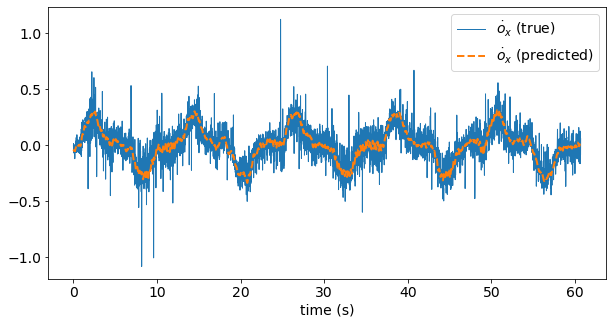

In [255]:
plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_x_dot_true, label='$\dot{o}_x$ (true)', linewidth=1)
plt.plot(t, o_x_dot_predicted, '--', label='$\dot{o}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $\dot{o}_x$.

In [256]:
o_x_dot_err = o_x_dot_predicted[:-1] - o_x_dot_true

Plot a histogram of the error, showing mean and standard deviation.

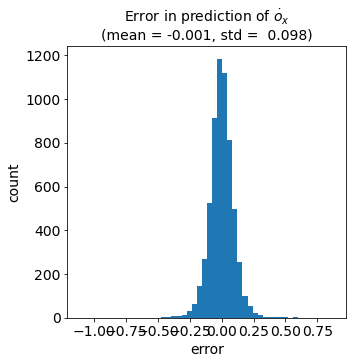

In [257]:
plt.figure(figsize=(5, 5))
plt.hist(o_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_x_dot_std = np.std(o_x_dot_err)
o_x_dot_mean = np.mean(o_x_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_x$\n' +
    f'(mean = {o_x_dot_mean:6.3f}, std = {o_x_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.2 Error in linear model of $\dot{o}_y$

len(o_y_dot_true) = 6069
         len(o_y) = 6070
           len(t) = 6070


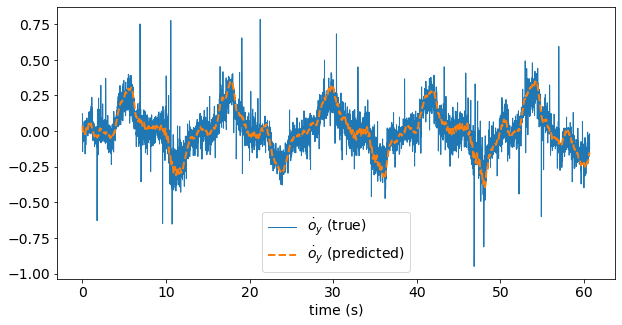

In [258]:
o_y_dot_true = (o_y[1:] - o_y[:-1]) / dt

print(f'len(o_y_dot_true) = {len(o_y_dot_true)}')
print(f'         len(o_y) = {len(o_y)}')
print(f'           len(t) = {len(t)}')

o_y_dot_predicted = v_y

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_y_dot_true, label='$\dot{o}_y$ (true)', linewidth=1)
plt.plot(t, o_y_dot_predicted, '--', label='$\dot{o}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

o_y_dot_err = o_y_dot_predicted[:-1] - o_y_dot_true

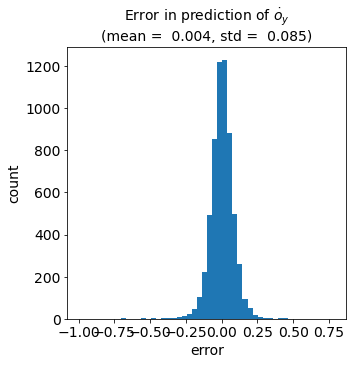

In [259]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(o_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_y_dot_std = np.std(o_y_dot_err)
o_y_dot_mean = np.mean(o_y_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_y$\n' +
    f'(mean = {o_y_dot_mean:6.3f}, std = {o_y_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.3 Error in linear model of $\dot{o}_z$

len(o_z_dot_true) = 6069
         len(o_z) = 6070
           len(t) = 6070


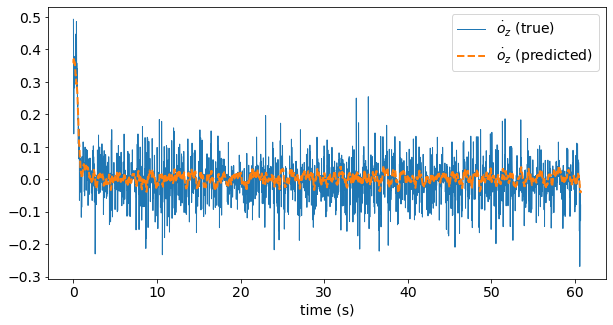

In [260]:
o_z_dot_true = (o_z[1:] - o_z[:-1]) / dt

print(f'len(o_z_dot_true) = {len(o_z_dot_true)}')
print(f'         len(o_z) = {len(o_z)}')
print(f'           len(t) = {len(t)}')

o_z_dot_predicted = v_z

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], o_z_dot_true, label='$\dot{o}_z$ (true)', linewidth=1)
plt.plot(t, o_z_dot_predicted, '--', label='$\dot{o}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

o_z_dot_err = o_z_dot_predicted[:-1] - o_z_dot_true

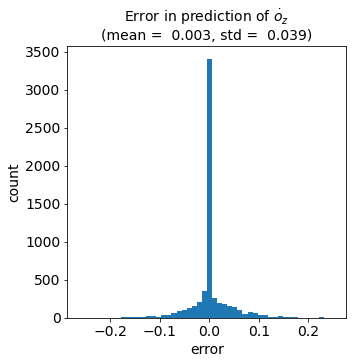

In [261]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(o_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

o_z_dot_std = np.std(o_z_dot_err)
o_z_dot_mean = np.mean(o_z_dot_err)

plt.title(
    'Error in prediction of $\dot{o}_z$\n' +
    f'(mean = {o_z_dot_mean:6.3f}, std = {o_z_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.4 Error in linear model of $\dot{\psi}$

len(psi_dot_true) = 6069
         len(psi) = 6070
           len(t) = 6070


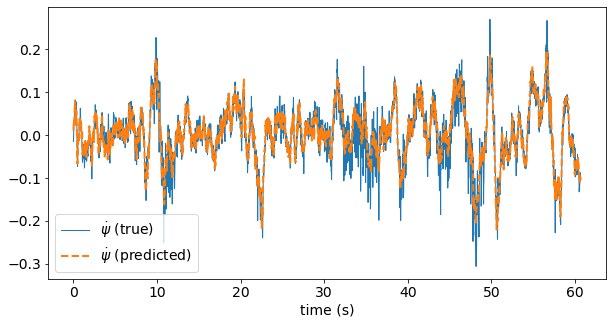

In [262]:
psi_dot_true = (psi[1:] - psi[:-1]) / dt

print(f'len(psi_dot_true) = {len(psi_dot_true)}')
print(f'         len(psi) = {len(psi)}')
print(f'           len(t) = {len(t)}')

psi_dot_predicted = w_z

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], psi_dot_true, label='$\dot{\psi}$ (true)', linewidth=1)
plt.plot(t, psi_dot_predicted, '--', label='$\dot{\psi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

psi_dot_err = psi_dot_predicted[:-1] - psi_dot_true

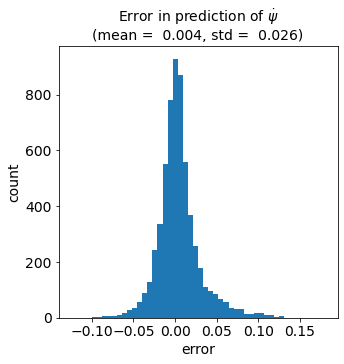

In [263]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(psi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

psi_dot_std = np.std(psi_dot_err)
psi_dot_mean = np.mean(psi_dot_err)

plt.title(
    'Error in prediction of $\dot{\psi}$\n' +
    f'(mean = {psi_dot_mean:6.3f}, std = {psi_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.5 Error in linear model of $\dot{\theta}$

len(theta_dot_true) = 6069
         len(theta) = 6070
           len(t) = 6070


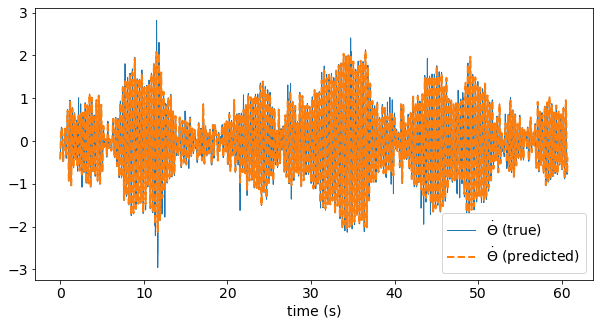

In [264]:
theta_dot_true = (theta[1:] - theta[:-1]) / dt

print(f'len(theta_dot_true) = {len(theta_dot_true)}')
print(f'         len(theta) = {len(theta)}')
print(f'           len(t) = {len(t)}')

theta_dot_predicted = w_y

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], theta_dot_true, label='$\dot{\Theta}$ (true)', linewidth=1)
plt.plot(t, theta_dot_predicted, '--', label='$\dot{\Theta}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

theta_dot_err = theta_dot_predicted[:-1] - theta_dot_true

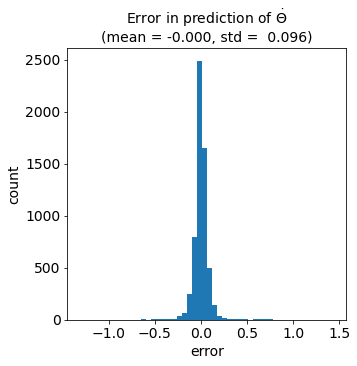

In [265]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(theta_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

theta_dot_std = np.std(theta_dot_err)
theta_dot_mean = np.mean(theta_dot_err)

plt.title(
    'Error in prediction of $\dot{\Theta}$\n' +
    f'(mean = {theta_dot_mean:6.3f}, std = {theta_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.6 Error in linear model of $\dot{\phi}$

len(phi_dot_true) = 6069
         len(phi) = 6070
           len(t) = 6070


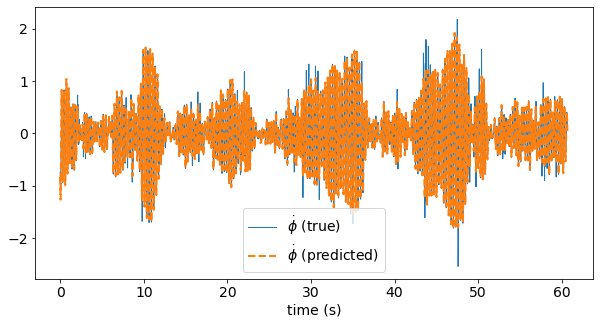

In [266]:
phi_dot_true = (phi[1:] - phi[:-1]) / dt

print(f'len(phi_dot_true) = {len(phi_dot_true)}')
print(f'         len(phi) = {len(phi)}')
print(f'           len(t) = {len(t)}')

phi_dot_predicted = w_x

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], phi_dot_true, label='$\dot{\phi}$ (true)', linewidth=1)
plt.plot(t, phi_dot_predicted, '--', label='$\dot{\phi}$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

phi_dot_err = phi_dot_predicted[:-1] - phi_dot_true

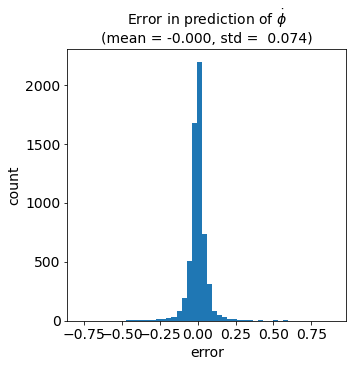

In [267]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(phi_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

phi_dot_std = np.std(phi_dot_err)
phi_dot_mean = np.mean(phi_dot_err)

plt.title(
    'Error in prediction of $\dot{\phi}$\n' +
    f'(mean = {phi_dot_mean:6.3f}, std = {phi_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.7 Error in linear model of $\dot{v}_x$

len(v_x_dot_true) = 6069
         len(v_x) = 6070
           len(t) = 6070


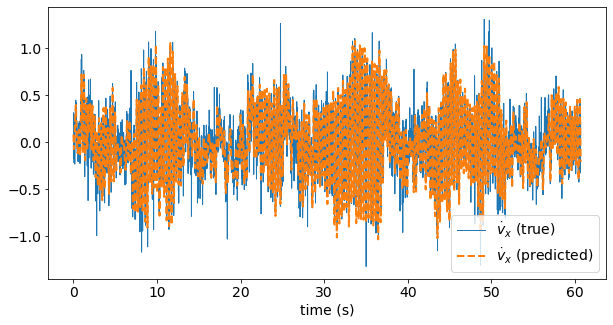

In [268]:
v_x_dot_true = (v_x[1:] - v_x[:-1]) / dt

print(f'len(v_x_dot_true) = {len(v_x_dot_true)}')
print(f'         len(v_x) = {len(v_x)}')
print(f'           len(t) = {len(t)}')

v_x_dot_predicted = g_val*theta

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_x_dot_true, label='$\dot{v}_x$ (true)', linewidth=1)
plt.plot(t, v_x_dot_predicted, '--', label='$\dot{v}_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_x_dot_err = v_x_dot_predicted[:-1] - v_x_dot_true

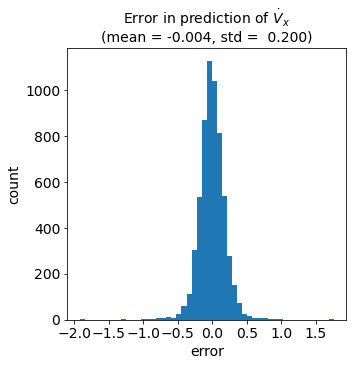

In [269]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_x_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_x_dot_std = np.std(v_x_dot_err)
v_x_dot_mean = np.mean(v_x_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_x$\n' +
    f'(mean = {v_x_dot_mean:6.3f}, std = {v_x_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.8 Error in linear model of $\dot{v}_y$

len(v_y_dot_true) = 6069
         len(v_y) = 6070
           len(t) = 6070


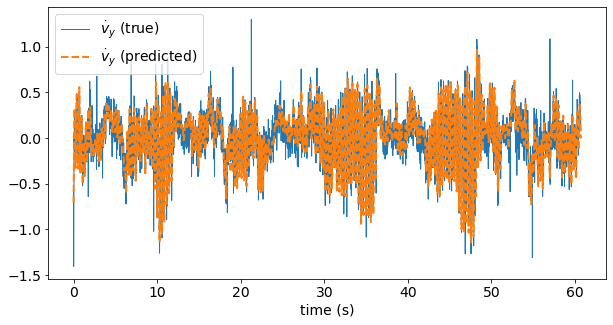

In [270]:
v_y_dot_true = (v_y[1:] - v_y[:-1]) / dt

print(f'len(v_y_dot_true) = {len(v_y_dot_true)}')
print(f'         len(v_y) = {len(v_y)}')
print(f'           len(t) = {len(t)}')

v_y_dot_predicted = -g_val*phi

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_y_dot_true, label='$\dot{v}_y$ (true)', linewidth=1)
plt.plot(t, v_y_dot_predicted, '--', label='$\dot{v}_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_y_dot_err = v_y_dot_predicted[:-1] - v_y_dot_true

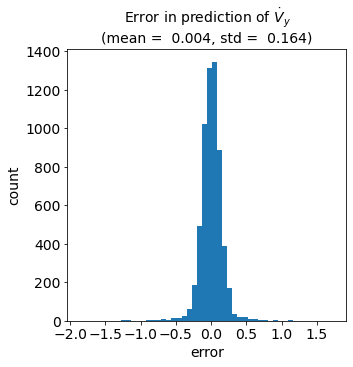

In [271]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_y_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_y_dot_std = np.std(v_y_dot_err)
v_y_dot_mean = np.mean(v_y_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_y$\n' +
    f'(mean = {v_y_dot_mean:6.3f}, std = {v_y_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.1.9 Error in linear model of $\dot{v}_z$

len(v_z_dot_true) = 6069
         len(v_z) = 6070
           len(t) = 6070


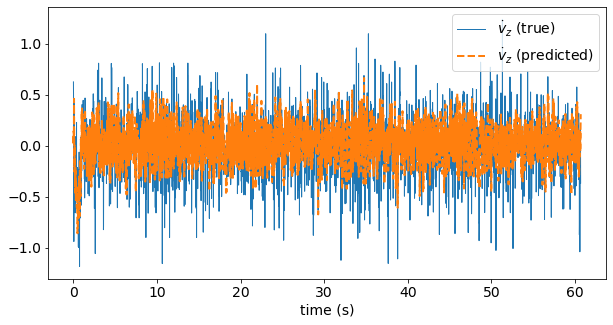

In [272]:
v_z_dot_true = (v_z[1:] - v_z[:-1]) / dt

print(f'len(v_z_dot_true) = {len(v_z_dot_true)}')
print(f'         len(v_z) = {len(v_z)}')
print(f'           len(t) = {len(t)}')

v_z_dot_predicted = a_z - g_val

plt.figure(figsize=(10, 5))
plt.plot(t[:-1], v_z_dot_true, label='$\dot{v}_z$ (true)', linewidth=1)
plt.plot(t, v_z_dot_predicted, '--', label='$\dot{v}_z$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

v_z_dot_err = v_z_dot_predicted[:-1] - v_z_dot_true

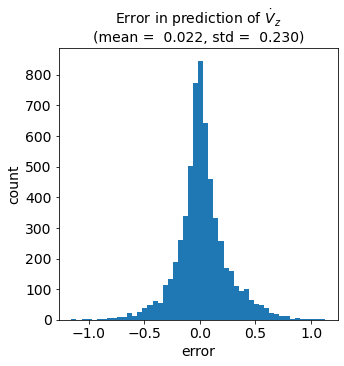

In [273]:
#Histogram
plt.figure(figsize=(5, 5))
plt.hist(v_z_dot_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

v_z_dot_std = np.std(v_z_dot_err)
v_z_dot_mean = np.mean(v_z_dot_err)

plt.title(
    'Error in prediction of $\dot{V}_z$\n' +
    f'(mean = {v_z_dot_mean:6.3f}, std = {v_z_dot_std:6.3f})',
    fontsize=14,
)
plt.show()

## 3.2 Error in linearized measurement equations

### 3.2.1 Error in linear model of $n_x$

Predict $n_x$ with the linearized measurement equations.

In particular, note that the first element of $y$ is $n_x$, and that the first element of $Cx+Du$ is

$$k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right),$$

so our linear model tells us that

$$n_x \approx k_\text{flow} \left( \dfrac{v_x}{o_\text{z, eq}} - w_y \right).$$

In [274]:
n_x_predicted = k_flow_val * ((v_x / o_z_eq) - w_y)

Compare the true value and the predicted values of $n_x$ in a plot.

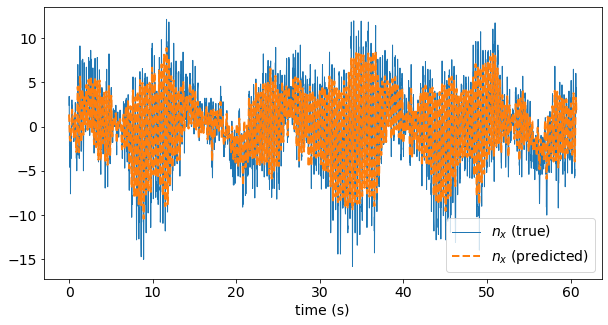

In [275]:
plt.figure(figsize=(10, 5))
plt.plot(t, n_x, label='$n_x$ (true)', linewidth=1)
plt.plot(t, n_x_predicted, '--', label='$n_x$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

Compute the error in the linear model, i.e., the difference between the predicted and true values of $n_x$.

In [276]:
n_x_err = n_x_predicted - n_x

Plot a histogram of the error, showing mean and standard deviation.

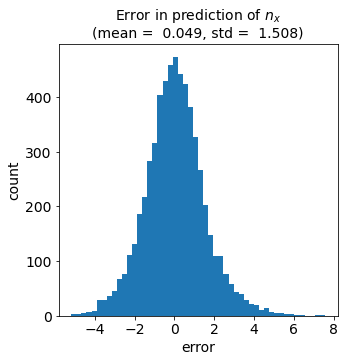

In [277]:
plt.figure(figsize=(5, 5))
plt.hist(n_x_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

n_x_std = np.std(n_x_err)
n_x_mean = np.mean(n_x_err)

plt.title(
    'Error in prediction of $n_x$\n' +
    f'(mean = {n_x_mean:6.3f}, std = {n_x_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.2 Error in linear model of $n_y$

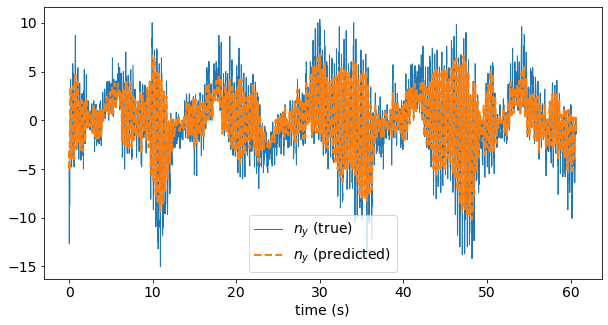

In [278]:
n_y_predicted = k_flow_val * ((v_y / o_z_eq) + w_x)

plt.figure(figsize=(10, 5))
plt.plot(t, n_y, label='$n_y$ (true)', linewidth=1)
plt.plot(t, n_y_predicted, '--', label='$n_y$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

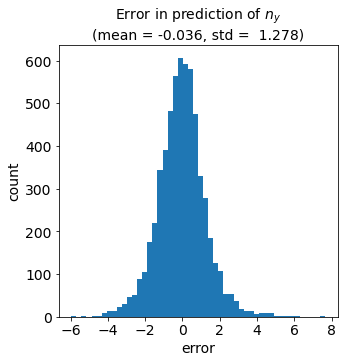

In [279]:
n_y_err = n_y_predicted - n_y

plt.figure(figsize=(5, 5))
plt.hist(n_y_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

n_y_std = np.std(n_y_err)
n_y_mean = np.mean(n_y_err)

plt.title(
    'Error in prediction of $n_y$\n' +
    f'(mean = {n_y_mean:6.3f}, std = {n_y_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.3 Error in linear model of $r$

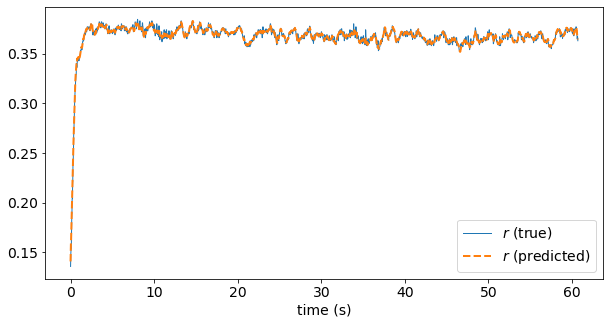

In [280]:
r_predicted = o_z

plt.figure(figsize=(10, 5))
plt.plot(t, r, label='$r$ (true)', linewidth=1)
plt.plot(t, r_predicted, '--', label='$r$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

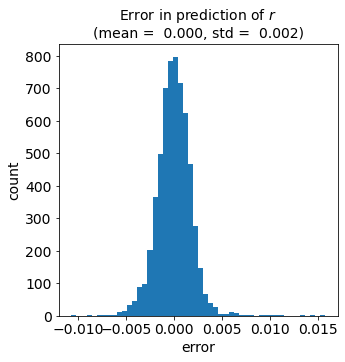

In [281]:
r_err = r_predicted - r

plt.figure(figsize=(5, 5))
plt.hist(r_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

r_std = np.std(r_err)
r_mean = np.mean(r_err)

plt.title(
    'Error in prediction of $r$\n' +
    f'(mean = {r_mean:6.3f}, std = {r_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.4 Error in linear model of $d_0$

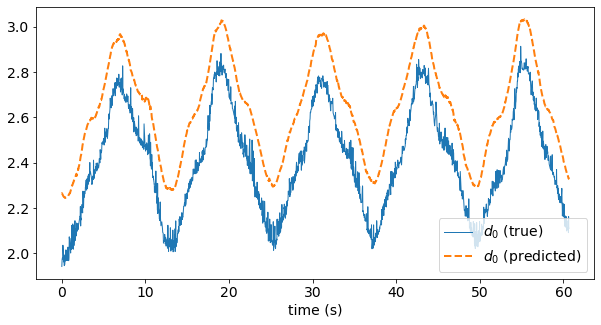

In [282]:
d_0_predicted = ((o_x - x0_val)**2 + (o_y - y0_val)**2 + (o_z - z0_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d0, label='$d_0$ (true)', linewidth=1)
plt.plot(t, d_0_predicted, '--', label='$d_0$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

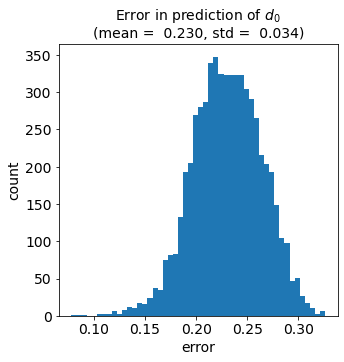

In [283]:
d_0_err = d_0_predicted - d0

plt.figure(figsize=(5, 5))
plt.hist(d_0_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_0_std = np.std(d_0_err)
d_0_mean = np.mean(d_0_err)

plt.title(
    'Error in prediction of $d_0$\n' +
    f'(mean = {d_0_mean:6.3f}, std = {d_0_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.5 Error in linear model of $d_1$

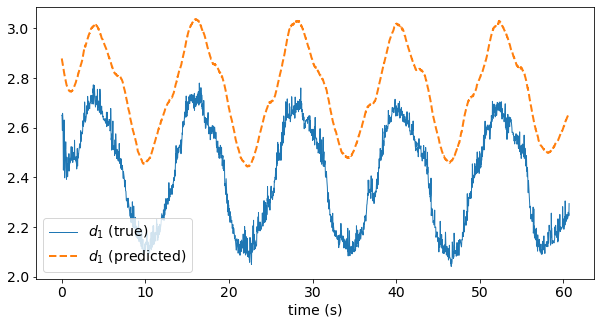

In [284]:
d_1_predicted = ((o_x - x1_val)**2 + (o_y - y1_val)**2 + (o_z - z1_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d1, label='$d_1$ (true)', linewidth=1)
plt.plot(t, d_1_predicted, '--', label='$d_1$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

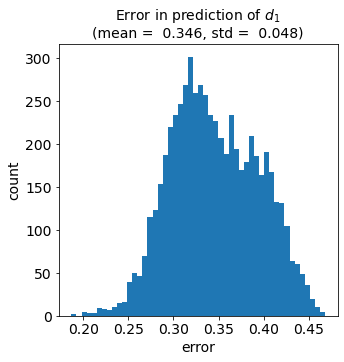

In [285]:
d_1_err = d_1_predicted - d1

plt.figure(figsize=(5, 5))
plt.hist(d_1_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_1_std = np.std(d_1_err)
d_1_mean = np.mean(d_1_err)

plt.title(
    'Error in prediction of $d_1$\n' +
    f'(mean = {d_1_mean:6.3f}, std = {d_1_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.6 Error in linear model of $d_2$

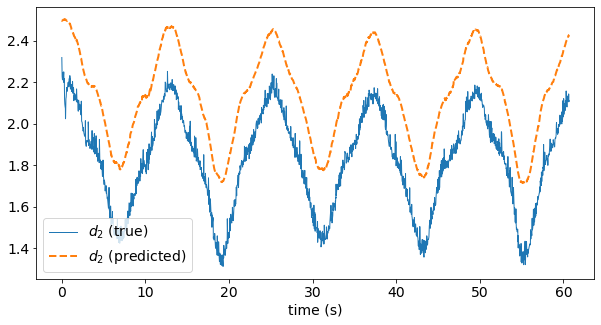

In [286]:
d_2_predicted = ((o_x - x2_val)**2 + (o_y - y2_val)**2 + (o_z - z2_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d2, label='$d_2$ (true)', linewidth=1)
plt.plot(t, d_2_predicted, '--', label='$d_2$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

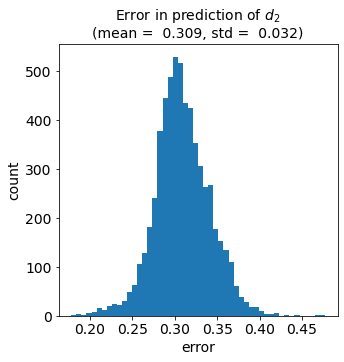

In [287]:
d_2_err = d_2_predicted - d2

plt.figure(figsize=(5, 5))
plt.hist(d_2_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_2_std = np.std(d_2_err)
d_2_mean = np.mean(d_2_err)

plt.title(
    'Error in prediction of $d_2$\n' +
    f'(mean = {d_2_mean:6.3f}, std = {d_2_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.7 Error in linear model of $d_3$

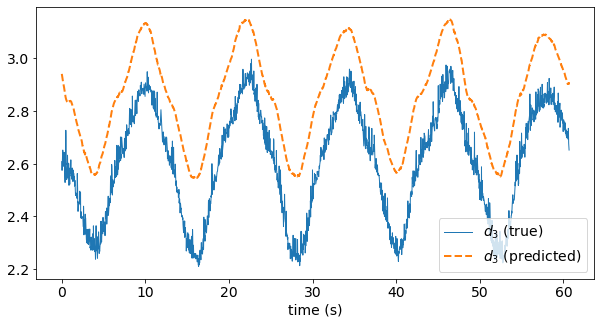

In [288]:
d_3_predicted = ((o_x - x3_val)**2 + (o_y - y3_val)**2 + (o_z - z3_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d3, label='$d_3$ (true)', linewidth=1)
plt.plot(t, d_3_predicted, '--', label='$d_3$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

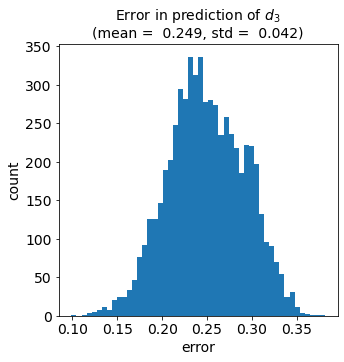

In [289]:
d_3_err = d_3_predicted - d3

plt.figure(figsize=(5, 5))
plt.hist(d_3_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_3_std = np.std(d_3_err)
d_3_mean = np.mean(d_3_err)

plt.title(
    'Error in prediction of $d_3$\n' +
    f'(mean = {d_3_mean:6.3f}, std = {d_3_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.8 Error in linear model of $d_4$

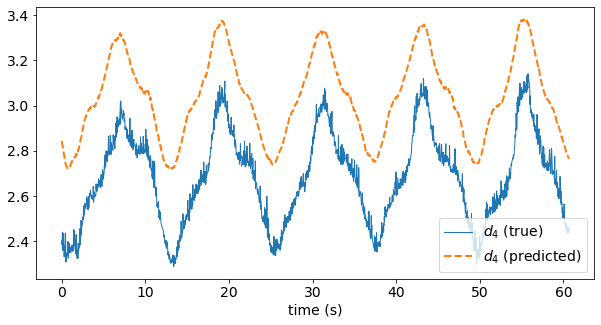

In [290]:
d_4_predicted = ((o_x - x4_val)**2 + (o_y - y4_val)**2 + (o_z - z4_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d4, label='$d_4$ (true)', linewidth=1)
plt.plot(t, d_4_predicted, '--', label='$d_4$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

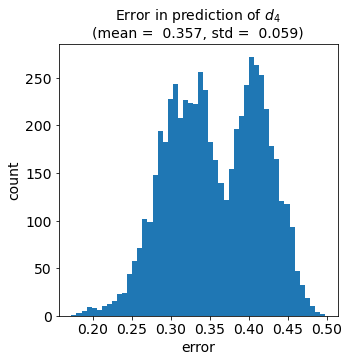

In [291]:
d_4_err = d_4_predicted - d4

plt.figure(figsize=(5, 5))
plt.hist(d_4_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_4_std = np.std(d_4_err)
d_4_mean = np.mean(d_4_err)

plt.title(
    'Error in prediction of $d_4$\n' +
    f'(mean = {d_4_mean:6.3f}, std = {d_4_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.9 Error in linear model of $d_5$

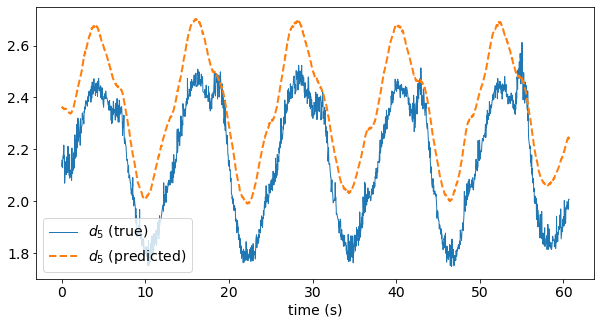

In [292]:
d_5_predicted = ((o_x - x5_val)**2 + (o_y - y5_val)**2 + (o_z - z5_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d5, label='$d_5$ (true)', linewidth=1)
plt.plot(t, d_5_predicted, '--', label='$d_5$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

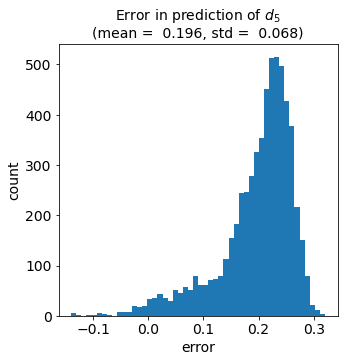

In [293]:
d_5_err = d_5_predicted - d5

plt.figure(figsize=(5, 5))
plt.hist(d_5_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_5_std = np.std(d_5_err)
d_5_mean = np.mean(d_5_err)

plt.title(
    'Error in prediction of $d_5$\n' +
    f'(mean = {d_5_mean:6.3f}, std = {d_5_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.10 Error in linear model of $d_6$

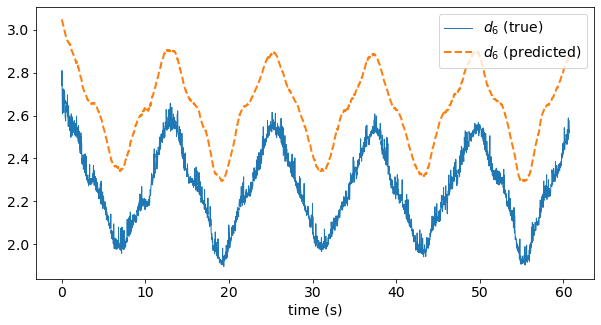

In [294]:
d_6_predicted = ((o_x - x6_val)**2 + (o_y - y6_val)**2 + (o_z - z6_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d6, label='$d_6$ (true)', linewidth=1)
plt.plot(t, d_6_predicted, '--', label='$d_6$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

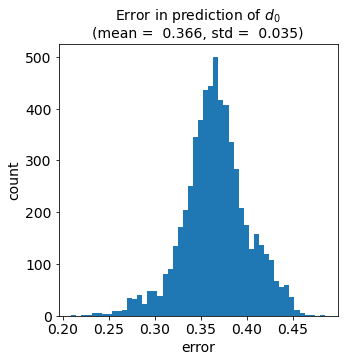

In [295]:
d_6_err = d_6_predicted - d6

plt.figure(figsize=(5, 5))
plt.hist(d_6_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_6_std = np.std(d_6_err)
d_6_mean = np.mean(d_6_err)

plt.title(
    'Error in prediction of $d_0$\n' +
    f'(mean = {d_6_mean:6.3f}, std = {d_6_std:6.3f})',
    fontsize=14,
)
plt.show()

### 3.2.11 Error in linear model of $d_7$

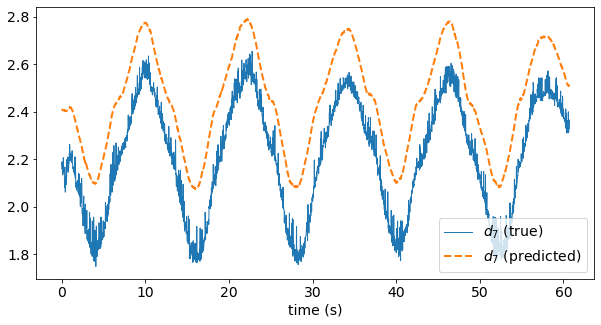

In [296]:
d_7_predicted = ((o_x - x7_val)**2 + (o_y - y7_val)**2 + (o_z - z7_val)**2)**(1/2)

plt.figure(figsize=(10, 5))
plt.plot(t, d7, label='$d_7$ (true)', linewidth=1)
plt.plot(t, d_7_predicted, '--', label='$d_7$ (predicted)', linewidth=2)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('time (s)', fontsize=14)
plt.show()

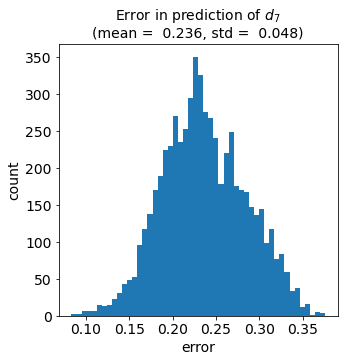

In [297]:
d_7_err = d_7_predicted - d7

plt.figure(figsize=(5, 5))
plt.hist(d_7_err, 50)
plt.xlabel('error', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

d_7_std = np.std(d_7_err)
d_7_mean = np.mean(d_7_err)

plt.title(
    'Error in prediction of $d_7$\n' +
    f'(mean = {d_7_mean:6.3f}, std = {d_7_std:6.3f})',
    fontsize=14,
)
plt.show()

## 3.3 Summary

The following table reports the mean and standard deviation of error in the linearized equations of motion:

|  | $\dot{o}_x$ | $\dot{o}_y$ | $\dot{o}_z$ | $\dot{\psi}$ | $\dot{\theta}$ | $\dot{\phi}$ | $\dot{v}_x$ | $\dot{v}_y$ | $\dot{v}_z$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.0003 | 0.008 | -0.0006 | 0.002 | 0.0001 | -0.0004 | 0.003 | 0.010 | 0.024 |
| std | 0.093 | 0.089 | 0.034 | 0.018 | 0.039 | 0.034 | 0.175 | 0.165 | 0.291 |

The following table reports the mean and standard deviation of error in the linearized measurement equations:

|  | $n_x$ | $n_y$ | $r$ | $d_0$ | $d_1$ | $d_2$ | $d_3$ | $d_4$ | $d_5$ | $d_6$ | $d_7$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| mean | 0.021 | -0.026 | 0.0005 | 0.176 | 0.350 | 0.309 | 0.227 | 0.320 | 0.123 | 0.266 | 0.223 |
| std | 1.148 | 1.019 | 0.003 | 0.051 | 0.040 | 0.050 | 0.042 | 0.054 | 0.131 | 0.029 | 0.066 |

# 4. Finalizing Observer

## 4.1. Verify Observability

Check if the system, in its current state, is fully observable

In [298]:
W_o = obsv(A_obs, C_obs)

print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 9


Unfortunately, it's not. We can remedy this by removing the states that are not observable. Yaw is the culprit here, so we must remove it from our observer model

In [299]:
s_obs_index = [
    0, # o_x
    1, # o_y
    2, # o_z
    4, # theta
    5, # phi
    6, # v_x
    7, # v_y
    8, # v_z
]

A_obs = A_obs[s_obs_index, :][:, s_obs_index]
B_obs = B_obs[s_obs_index, :]
C_obs = C_obs[:, s_obs_index]
D_obs = D_obs

Verify that the new system is fully observable

In [300]:
W_o = obsv(A_obs, C_obs)

print(f'      rank of W_o is: {np.linalg.matrix_rank(W_o)}')
print(f'"full rank" would be: {A_obs.shape[0]}')

      rank of W_o is: 8
"full rank" would be: 8


## 4.2. Compute the Gain Matrix $L$ for the Observer

Create the weights matrices, $Q$ and $R$, using the standard deviation in the corresponding measurement that was found in Section 3.

In [301]:
Q_obs = np.diag([
    (1/n_x_std)**2,    # n_x
    (1/n_y_std)**2,    # n_y
    (1/r_std)**2,      # r
    (1/d_0_std)**2,    # d0
    (1/d_1_std)**2,    # d1
    (1/d_2_std)**2,    # d2
    (1/d_3_std)**2,    # d3
    (1/d_4_std)**2,    # d4
    (1/d_5_std)**2,    # d5
    (1/d_6_std)**2,    # d6
    (1/d_7_std)**2,    # d7
])

R_obs = np.diag([
    (1/o_x_dot_std)**2,   # o_x
    (1/o_y_dot_std)**2,   # o_y
    (1/o_z_dot_std)**2,   # o_z
    (1/theta_dot_std)**2, # theta
    (1/phi_dot_std)**2,   # phi
    (1/v_x_dot_std)**2,   # v_x
    (1/v_y_dot_std)**2,   # v_y
    (1/v_z_dot_std)**2,   # v_z
])

Plug $Q$ and $R$ into an LQR function to solve for the matrix of gains $L$ for the observer

In [302]:
L = lqr(A_obs.T, C_obs.T, linalg.inv(R_obs), linalg.inv(Q_obs)).T
print(L)

[[ 3.33078350e-02 -6.04510261e-03 -5.71598638e-01  1.77920821e+00
   1.06328350e+00 -2.09946547e+00 -1.56555849e+00  5.07109837e-01
   6.40958002e-01 -1.55006609e+00 -1.39874435e+00]
 [-4.44348237e-03  3.71503594e-02 -2.67771328e-01  1.67846012e+00
  -1.09778396e+00 -1.72261297e+00  1.31136263e+00  4.55556104e-01
  -6.44238003e-01 -1.24157195e+00  1.15395202e+00]
 [-1.59920575e-05 -1.01288869e-05  2.72430551e+01  4.26652689e-03
  -1.91402301e-02  7.09377626e-03 -2.37958437e-02 -1.38272533e-02
   1.24940230e-03 -3.06044533e-02  3.10967563e-03]
 [ 4.84905641e-02 -2.16750201e-03 -2.05389841e-01  7.61710604e-01
   3.63646449e-01 -8.87565479e-01 -5.48768301e-01  2.16092379e-01
   2.19985936e-01 -6.54020287e-01 -4.91041540e-01]
 [ 1.53841472e-03 -4.58950888e-02  9.10105219e-02 -5.93252661e-01
   3.26319778e-01  6.16429864e-01 -3.81602339e-01 -1.61680912e-01
   1.91026406e-01  4.45328291e-01 -3.35221756e-01]
 [ 2.49745658e-01 -1.62284712e-02 -1.40032927e+00  4.78504805e+00
   2.50131178e+00 -

# 5. Tests and Plots

## 5.1. Import and parse data

Import

In [315]:
data = load_hardware_data(
    'final_testing1_1gram_funky2.json',   # <-- FIXME: replace with name of file with data
    t_min_offset=3.,
    t_max_offset=3.,
    only_in_flight=False
)

Parse

In [316]:
# time
t = data['time']

# states
o_x_true = data['ae483log.o_x']
o_y_true = data['ae483log.o_y']
o_z_true = data['ae483log.o_z']
psi_true = data['ae483log.psi']
theta_true = data['ae483log.theta']
phi_true = data['ae483log.phi']
v_x_true = data['ae483log.v_x']
v_y_true = data['ae483log.v_y']
v_z_true = data['ae483log.v_z']

# inputs
w_x_true = data['ae483log.w_x']
w_y_true = data['ae483log.w_y']
w_z_true = data['ae483log.w_z']
a_z_true = data['ae483log.a_z']

# outputs
n_x_true = data['ae483log.n_x']
n_y_true = data['ae483log.n_y']
r_true = data['ae483log.r']
d0_true = data['ae483log.d0']
d1_true = data['ae483log.d1']
d2_true = data['ae483log.d2']
d3_true = data['ae483log.d3']
d4_true = data['ae483log.d4']
d5_true = data['ae483log.d5']
d6_true = data['ae483log.d6']
d7_true = data['ae483log.d7']

# Time step (should be 0.01)
dt = t[1] - t[0]
print(f'dt = {dt:.4f} (should be 0.01)')

dt = 0.0100 (should be 0.01)


Feed parsed data through offline observer

In [317]:
# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_hat = np.zeros(len(t))
o_y_hat = np.zeros(len(t))
o_z_hat = np.zeros(len(t))
psi_hat = np.zeros(len(t))
theta_hat = np.zeros(len(t))
phi_hat = np.zeros(len(t))
v_x_hat = np.zeros(len(t))
v_y_hat = np.zeros(len(t))
v_z_hat = np.zeros(len(t))

x_hat = np.array([[o_x_hat],
                  [o_y_hat],
                  [o_z_hat],
                  [psi_hat],
                  [theta_hat],
                  [phi_hat],
                  [v_x_hat],
                  [v_y_hat],
                  [v_z_hat]])

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_true[i]
    w_y = w_y_true[i]
    w_z = w_z_true[i]
    a_z = a_z_true[i]
    n_x = n_x_true[i]
    n_y = n_y_true[i]
    r = r_true[i]
    d0 = d0_true[i]
    d1 = d1_true[i]
    d2 = d2_true[i]
    d3 = d3_true[i]
    d4 = d4_true[i]
    d5 = d5_true[i]
    d6 = d6_true[i]
    d7 = d7_true[i]
    
    # Compute each element of:
    #
    #  C x + D u - y
    #
    n_x_err = (k_flow_val * ((v_x / o_z_eq) - w_y)) - n_x # <-- FIXME
    n_y_err = (k_flow_val * ((v_y / o_z_eq) + w_x)) - n_y  # <-- FIXME
    r_err = o_z  - r  # <-- FIXME

    d0_err = ((o_x - x0_val)**2 + (o_y - y0_val)**2 + (o_z - z0_val)**2)**(1/2) - d0
    d1_err = ((o_x - x1_val)**2 + (o_y - y1_val)**2 + (o_z - z1_val)**2)**(1/2) - d1
    d2_err = ((o_x - x2_val)**2 + (o_y - y2_val)**2 + (o_z - z2_val)**2)**(1/2) - d2
    d3_err = ((o_x - x3_val)**2 + (o_y - y3_val)**2 + (o_z - z3_val)**2)**(1/2) - d3
    d4_err = ((o_x - x4_val)**2 + (o_y - y4_val)**2 + (o_z - z4_val)**2)**(1/2) - d4
    d5_err = ((o_x - x5_val)**2 + (o_y - y5_val)**2 + (o_z - z5_val)**2)**(1/2) - d5
    d6_err = ((o_x - x6_val)**2 + (o_y - y6_val)**2 + (o_z - z6_val)**2)**(1/2) - d6
    d7_err = ((o_x - x7_val)**2 + (o_y - y7_val)**2 + (o_z - z7_val)**2)**(1/2) - d7

    o_err = np.array([[n_x_err], [n_y_err], [r_err], [d0_err], [d1_err], [d2_err], [d3_err], [d4_err], [d5_err], [d6_err], [d7_err]])
    
    
    # Update estimates

    L_times_err = L @ o_err
    
    # if i == 0:
    #     print(L_times_err)

    o_x += dt * (v_x - L_times_err[0][0])
    # print(o_x)
    # print(v_x)
    # print(L_times_err[0][0])
    o_y += dt * (v_y - L_times_err[1][0])
    o_z += dt * (v_z - L_times_err[2][0])
    psi += dt * (w_z)  # <-- FIXME
    theta += dt * (w_y - L_times_err[3][0]) # <-- FIXME
    phi += dt * (w_x - L_times_err[4][0])  # <-- FIXME
    v_x += dt * (g_val*theta - L_times_err[5][0])  # <-- FIXME
    v_y += dt * (-g_val*phi - L_times_err[6][0])   # <-- FIXME
    v_z += dt * (a_z-g_val - L_times_err[7][0])   # <-- FIXME

    # Store estimates (do not change)
    o_x_hat[i] = o_x
    o_y_hat[i] = o_y
    o_z_hat[i] = o_z
    psi_hat[i] = psi
    theta_hat[i] = theta
    phi_hat[i] = phi
    v_x_hat[i] = v_x
    v_y_hat[i] = v_y
    v_z_hat[i] = v_z

## 5.2. Plot data

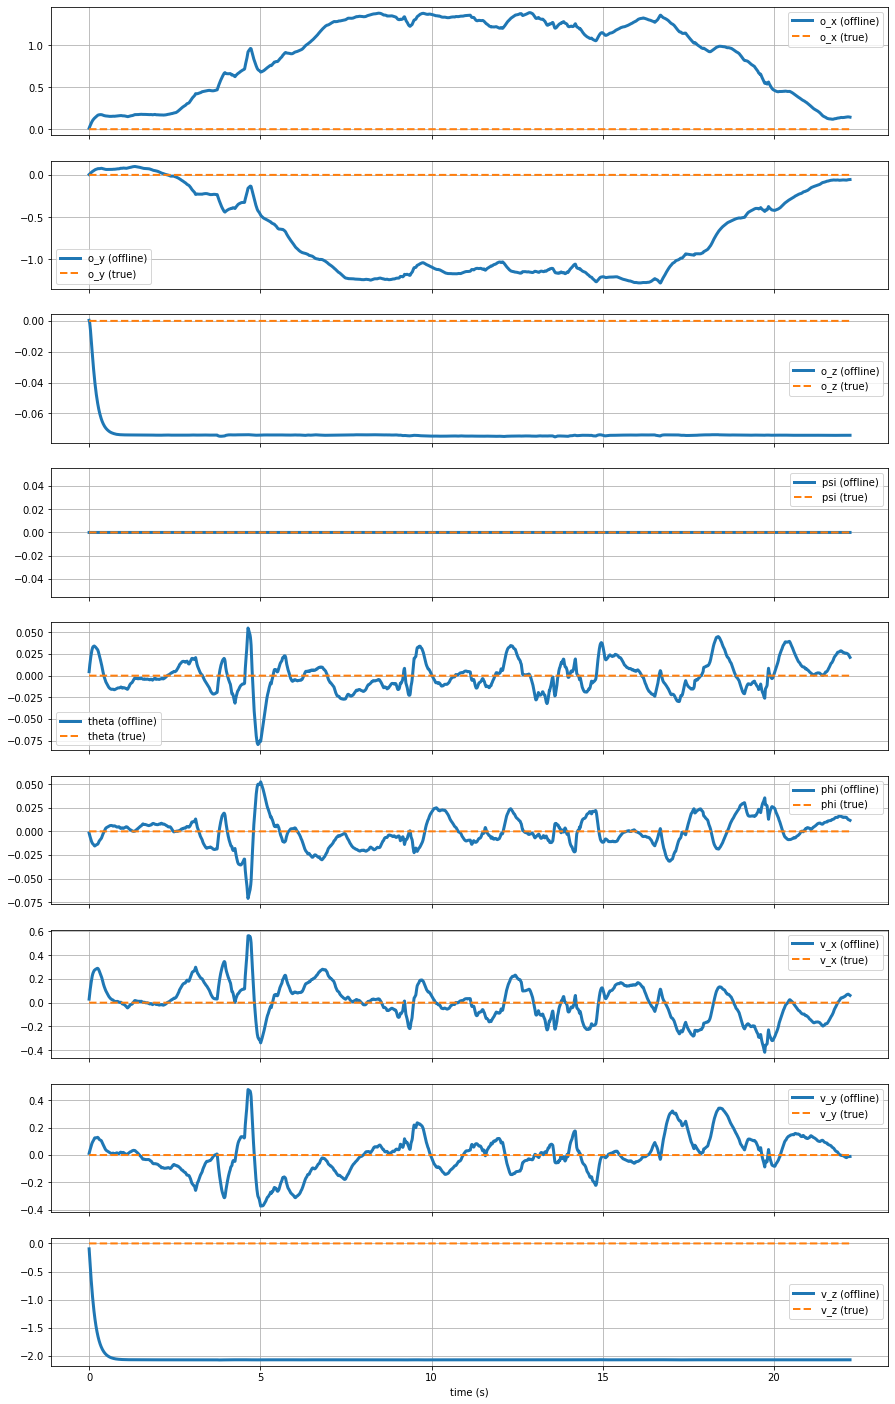

In [318]:
def comparison_plot(t, s_hat, s_true, name, ax):
    ax.plot(t, s_hat, label=f'{name} (offline)', linewidth=3)
    ax.plot(t, s_true, '--', label=f'{name} (true)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)
comparison_plot(t, o_x_hat, o_x_true, 'o_x', ax_o_x)
comparison_plot(t, o_y_hat, o_y_true, 'o_y', ax_o_y)
comparison_plot(t, o_z_hat, o_z_true, 'o_z', ax_o_z)
comparison_plot(t, psi_hat, psi_true, 'psi', ax_psi)
comparison_plot(t, theta_hat, theta_true, 'theta', ax_theta)
comparison_plot(t, phi_hat, phi_true, 'phi', ax_phi)
comparison_plot(t, v_x_hat, v_x_true, 'v_x', ax_v_x)
comparison_plot(t, v_y_hat, v_y_true, 'v_y', ax_v_y)
comparison_plot(t, v_z_hat, v_z_true, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')
plt.show()